In [1]:
#! pip install pymc-marketing

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
import warnings

import arviz as az
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

In [3]:
warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
# Loading the Dataset
data = pd.read_csv("/Documents/MMM/mmm.csv")

In [5]:
data.head(10)

,Unnamed: 0,time.index,tv.volume,tv.spend,search.clicks,search.imps,search.matching.query.volume,search.query.volume,search.spend,total.spend,brand.sales,competitor.sales,revenue,profit,tv.budget.index,tv.budget,search.budget.index,search.budget
0,1,53,0,0.000000e+00,0,0,3925234,17454556,0.0,0.000000e+00,1464929,8149405,117194320,1.171943e+08,2,47500000.0,2,12000000.0
1,2,54,1089276931,5.446534e+06,344738,4385017,4385017,19495548,379211.8,5.825746e+06,1824453,9169015,145956240,1.401305e+08,2,47500000.0,2,12000000.0
2,3,55,0,0.000000e+00,327228,4202279,4202279,18674739,359950.8,3.599508e+05,1593647,8850791,127491760,1.271318e+08,2,47500000.0,2,12000000.0
3,4,56,779008559,3.894953e+06,398409,5005803,5005803,22248392,438249.9,4.333203e+06,2109265,10658782,168741200,1.644080e+08,2,47500000.0,2,12000000.0
4,5,57,0,0.000000e+00,407746,5105357,5105357,22689299,448520.6,4.485206e+05,1983664,11031917,158693120,1.582446e+08,2,47500000.0,2,12000000.0
5,6,58,539284967,2.696375e+06,381706,4812649,4812649,21399239,419876.6,3.116252e+06,2005426,10199658,160434080,1.573178e+08,2,47500000.0,2,12000000.0
6,7,59,0,0.000000e+00,327722,4197810,4197810,18649704,360494.2,3.604942e+05,1588124,8839717,127049920,1.266894e+08,2,47500000.0,2,12000000.0
7,8,60,420645871,2.103286e+06,294613,3824582,3824582,17003987,324074.3,2.427360e+06,1538483,7853494,123078640,1.206513e+08,2,47500000.0,2,12000000.0
8,9,61,0,0.000000e+00,320321,4128217,4128217,18343497,352353.1,3.523531e+05,1560196,8675976,124815680,1.244633e+08,2,47500000.0,2,12000000.0
9,10,62,466865838,2.334387e+06,335432,4286743,4286743,19064362,368975.2,2.703362e+06,1758222,8949226,140657760,1.379544e+08,2,47500000.0,2,12000000.0


In [6]:
data.drop(columns=["Unnamed: 0"], inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   time.index                    156 non-null    int64  
 1   tv.volume                     156 non-null    int64  
 2   tv.spend                      156 non-null    float64
 3   search.clicks                 156 non-null    int64  
 4   search.imps                   156 non-null    int64  
 5   search.matching.query.volume  156 non-null    int64  
 6   search.query.volume           156 non-null    int64  
 7   search.spend                  156 non-null    float64
 8   total.spend                   156 non-null    float64
 9   brand.sales                   156 non-null    int64  
 10  competitor.sales              156 non-null    int64  
 11  revenue                       156 non-null    int64  
 12  profit                        156 non-null    float64
 13  tv.bu

In [8]:
data.describe()

,time.index,tv.volume,tv.spend,search.clicks,search.imps,search.matching.query.volume,search.query.volume,search.spend,total.spend,brand.sales,competitor.sales,revenue,profit,tv.budget.index,tv.budget,search.budget.index,search.budget
count,156.000000,1.560000e+02,1.560000e+02,156.000000,1.560000e+02,1.560000e+02,1.560000e+02,156.000000,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,156.000000,1.560000e+02,156.000000,1.560000e+02
mean,130.500000,1.730752e+08,8.653846e+05,315967.044872,4.207188e+06,4.969196e+06,1.470570e+07,347563.749359,1.212948e+06,1.241617e+06,6.668882e+06,9.932939e+07,9.811644e+07,3.000000,4.500000e+07,3.000000,1.800000e+07
std,45.177428,2.557752e+08,1.278889e+06,200596.569821,2.545892e+06,1.936581e+06,3.892745e+06,220656.226803,1.305055e+06,4.003445e+05,2.105946e+06,3.202756e+07,3.165117e+07,0.819126,2.280351e+06,0.819126,4.914757e+06
min,53.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.833205e+06,8.147354e+06,0.000000,0.000000e+00,5.613870e+05,3.118096e+06,4.491096e+07,4.489346e+07,2.000000,4.200000e+07,2.000000,1.200000e+07
25%,91.750000,0.000000e+00,0.000000e+00,193154.000000,2.711724e+06,3.671494e+06,1.112414e+07,212469.400000,3.280817e+05,8.767255e+05,4.745538e+06,7.013804e+07,6.919556e+07,2.000000,4.200000e+07,2.000000,1.200000e+07
50%,130.500000,0.000000e+00,0.000000e+00,321727.500000,4.207117e+06,4.628674e+06,1.438107e+07,353900.250000,5.835538e+05,1.205290e+06,6.478346e+06,9.642320e+07,9.546933e+07,3.000000,4.550000e+07,3.000000,1.800000e+07
75%,169.250000,3.030393e+08,1.515215e+06,437435.000000,5.718354e+06,6.191451e+06,1.791146e+07,481178.500000,1.924798e+06,1.560262e+06,8.412969e+06,1.248209e+08,1.225360e+08,4.000000,4.750000e+07,4.000000,2.400000e+07
max,208.000000,1.089277e+09,5.446534e+06,821813.000000,1.029838e+07,1.029838e+07,2.288058e+07,903994.300000,5.825746e+06,2.148049e+06,1.118451e+07,1.718439e+08,1.692871e+08,4.000000,4.750000e+07,4.000000,2.400000e+07


In [9]:
# Data preprocessing
# Remove irrelevant columns
data.drop(columns=["time.index"], inplace=True)

In [10]:
data.head(10)

,tv.volume,tv.spend,search.clicks,search.imps,search.matching.query.volume,search.query.volume,search.spend,total.spend,brand.sales,competitor.sales,revenue,profit,tv.budget.index,tv.budget,search.budget.index,search.budget
0,0,0.000000e+00,0,0,3925234,17454556,0.0,0.000000e+00,1464929,8149405,117194320,1.171943e+08,2,47500000.0,2,12000000.0
1,1089276931,5.446534e+06,344738,4385017,4385017,19495548,379211.8,5.825746e+06,1824453,9169015,145956240,1.401305e+08,2,47500000.0,2,12000000.0
2,0,0.000000e+00,327228,4202279,4202279,18674739,359950.8,3.599508e+05,1593647,8850791,127491760,1.271318e+08,2,47500000.0,2,12000000.0
3,779008559,3.894953e+06,398409,5005803,5005803,22248392,438249.9,4.333203e+06,2109265,10658782,168741200,1.644080e+08,2,47500000.0,2,12000000.0
4,0,0.000000e+00,407746,5105357,5105357,22689299,448520.6,4.485206e+05,1983664,11031917,158693120,1.582446e+08,2,47500000.0,2,12000000.0
5,539284967,2.696375e+06,381706,4812649,4812649,21399239,419876.6,3.116252e+06,2005426,10199658,160434080,1.573178e+08,2,47500000.0,2,12000000.0
6,0,0.000000e+00,327722,4197810,4197810,18649704,360494.2,3.604942e+05,1588124,8839717,127049920,1.266894e+08,2,47500000.0,2,12000000.0
7,420645871,2.103286e+06,294613,3824582,3824582,17003987,324074.3,2.427360e+06,1538483,7853494,123078640,1.206513e+08,2,47500000.0,2,12000000.0
8,0,0.000000e+00,320321,4128217,4128217,18343497,352353.1,3.523531e+05,1560196,8675976,124815680,1.244633e+08,2,47500000.0,2,12000000.0
9,466865838,2.334387e+06,335432,4286743,4286743,19064362,368975.2,2.703362e+06,1758222,8949226,140657760,1.379544e+08,2,47500000.0,2,12000000.0


In [11]:
# Select features and target variable
selected_features = ['tv.spend', 'search.spend', 'revenue']
sale_spend = data[selected_features]

In [12]:
# Feature Engineering

# Create lag variables for 1y for revenue and channels to look for seasonality
sale_spend = pd.concat([sale_spend, sale_spend.shift(52).add_suffix('_lag1y')], axis=1)
sale_spend['revenue_lag1w'] = sale_spend['revenue'].shift()
sale_spend['revenue_lag3m'] = sale_spend['revenue'].shift(13)

In [13]:
# Drop extra columns generated from column shift and concatenation
sale_spend = sale_spend.dropna()

In [14]:
# PyMC MMM Model

with pm.Model() as mmm_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_tv = pm.Normal('beta_tv', mu=0, sigma=1)
    beta_search = pm.Normal('beta_search', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear relationship
    mu = alpha + beta_tv * sale_spend['tv.spend'] + beta_search * sale_spend['search.spend']

    # Likelihood
    revenue_obs = pm.Normal('revenue_obs', mu=mu, sigma=sigma, observed=sale_spend['revenue'])


In [15]:
# Model fitting
with mmm_model:
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_tv, beta_search, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


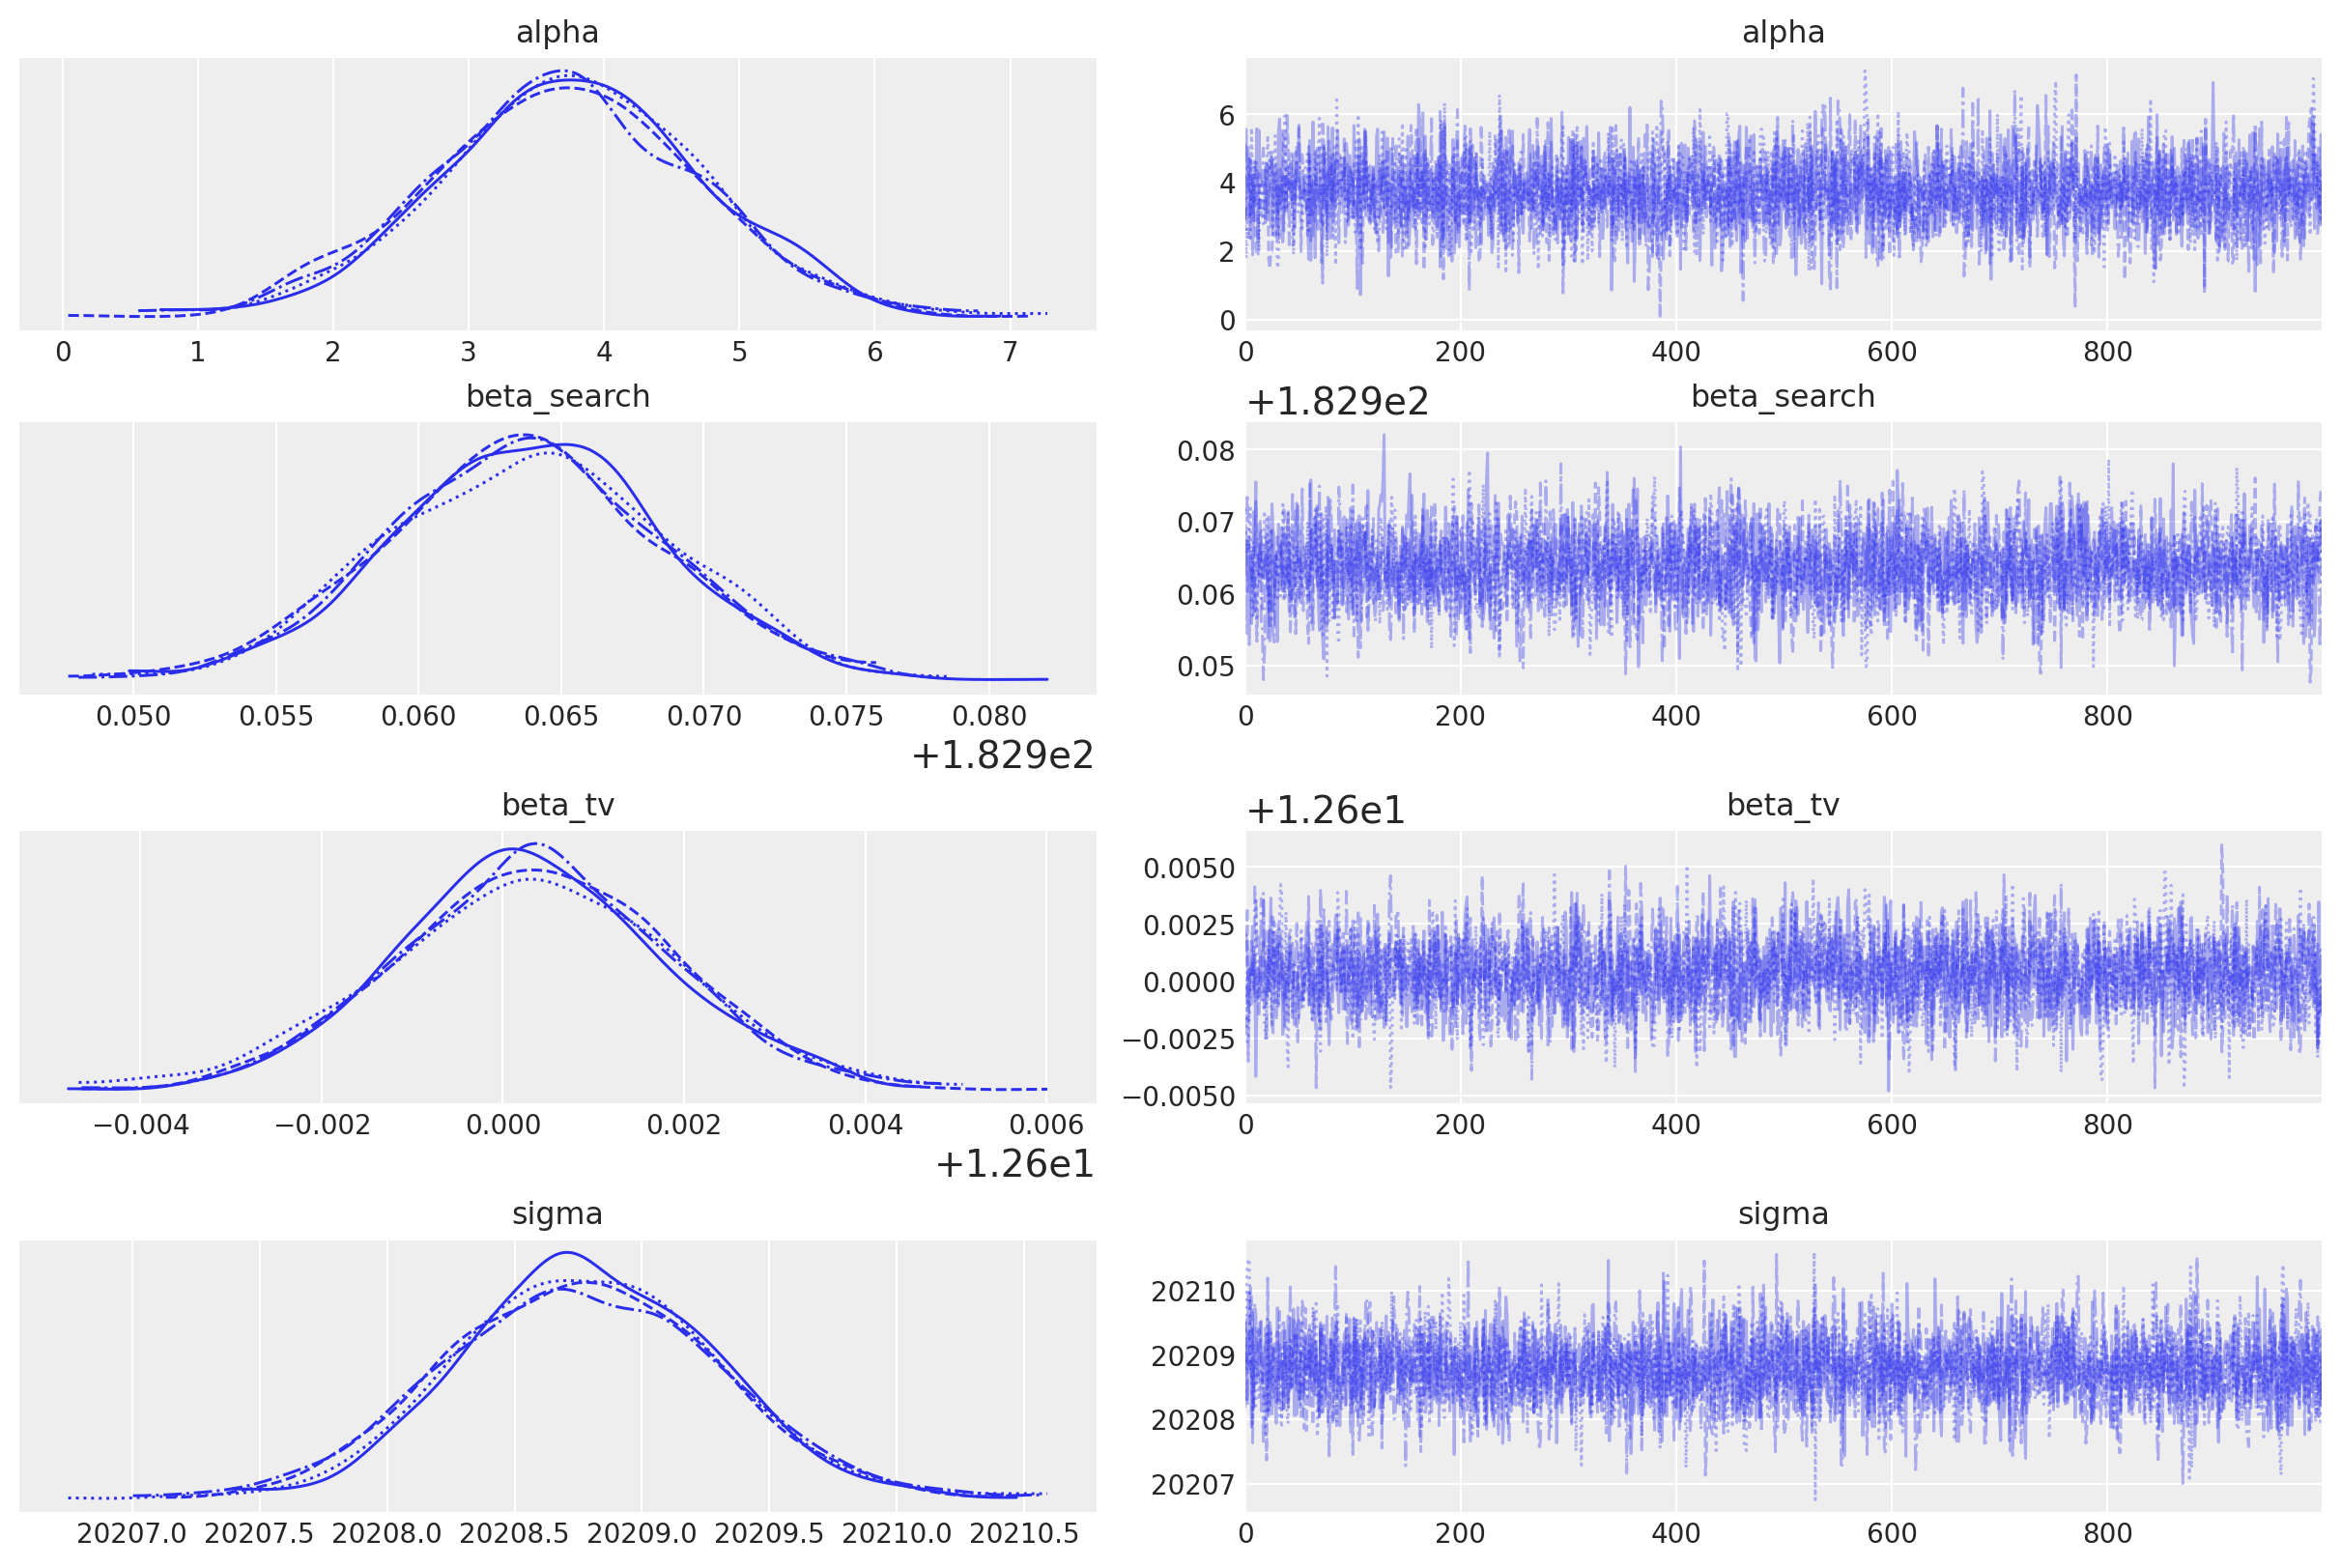

In [16]:
# Model evaluation
az.plot_trace(trace)
plt.show()

In [17]:
# Summary statistics
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.736,0.984,1.835,5.587,0.015,0.011,4363.0,2891.0,1.0
beta_search,182.964,0.005,182.955,182.973,0.000,0.000,2863.0,2872.0,1.0
beta_tv,12.600,0.002,12.597,12.603,0.000,0.000,3112.0,2975.0,1.0
sigma,20208.776,0.520,20207.792,20209.720,0.008,0.006,4384.0,3162.0,1.0


In [ ]:
# The summary statistics provide information about the posterior distributions of the model parameters. 
# Here's how to interpret the results and understand the impact on revenue:

# alpha: The mean value of alpha is 3.736 with a standard deviation of 0.984. 
# This represents the intercept term in the model. It indicates the baseline revenue 
# when both TV spend and search spend are zero.

# beta_search: The mean value of beta_search is 182.964 with a very small standard deviation of 0.005. 
# This indicates that for every unit increase in search spend, 
# there is an average increase of approximately $182.96 in revenue.

# beta_tv: The mean value of beta_tv is 12.600 with a very small standard deviation of 0.002. 
# This indicates that for every unit increase in TV spend, 
# there is an average increase of approximately $12.60 in revenue.

# sigma: The mean value of sigma is 20208.776, which represents the standard deviation of 
# the error term in the model. This indicates the variability of the observed revenue around 
# the predicted values by the model.

In [20]:
## Increasing search spend by one unit is estimated to have 
## a much larger impact on revenue compared to increasing TV spend by one unit.

## The standard deviation of the error term (sigma) is relatively large, suggesting that 
## there is still unexplained variability in revenue that is not captured by the model.

## In summary, according to this model, search spend has a larger impact on revenue compared to TV spend. 
## However, it's essential to consider other factors and conduct further analysis to validate 
## these findings and make informed decisions about marketing strategy.